# Background

Google Earth Engine script and the demo image collection (5 Heron Reef images) are available at:
+ https://code.earthengine.google.com/057bbb13a202ee027553327e842d2500
+ https://code.earthengine.google.com/?asset=users/mkbennett46/Drone_Classification_Demo



+ Users will need to sign up for a Google Earth Engine account (earthengine.google.com). This requires an email address. Users will also need to create a Google Cloud Storage Bucket, as results and files are exported to designated buckets from GEE.


+ After creating an account, we upload the drone images as assets into Google Earth Engine (GEE). We create an image collection of images we want to use to collect training and validation data.

+ Then, we manually draw polygons over areas in the drone images that represent the classes we want to classify and create 8,000 random points per class to evenly sample for training and validation data. 



+ We split the data into 70% training data and 30% validation data and train the Random Forest Classifier with the 70% training data. We complete an accuracy test to see how well the classifier distinguishes between classes in the training dataset. 



+ Then, we classify the validation data and generate a confusion matrix to assess the accuracy of the classification.



+ After accuracy assessment, we classify the drone imagery. 


+ In addition to classifying the drone imagery, we include code to generate and export a .CSV file containing the areas (m2) of each class per drone image. We also include code to export classifications of single drone images. 


*note: To classify our set of 230 images, we created a small image collection of images (n= 16) to select training data and complete accuracy assessment. Then we classified the whole image collection (n= 230) with Random Forest. 


# Getting Started
## Upload drone images as assets into Google Earth Engine 

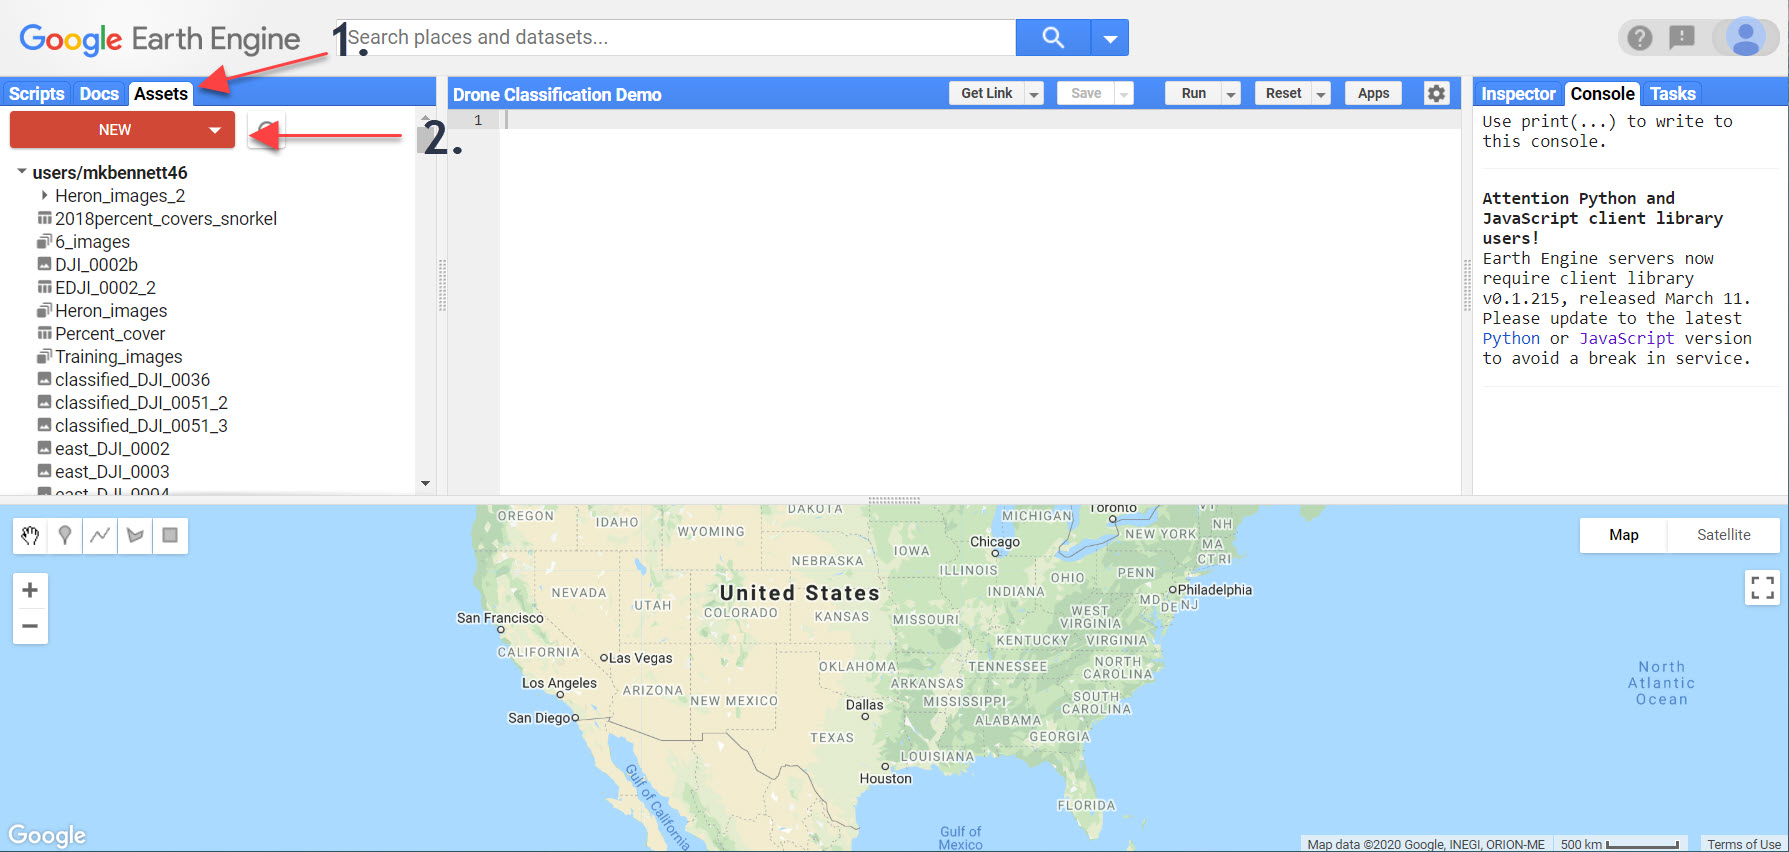



Under "Image Upload" we choose "GeoTIFF". We give the GeoTIFF we want to upload a unique asset ID. 


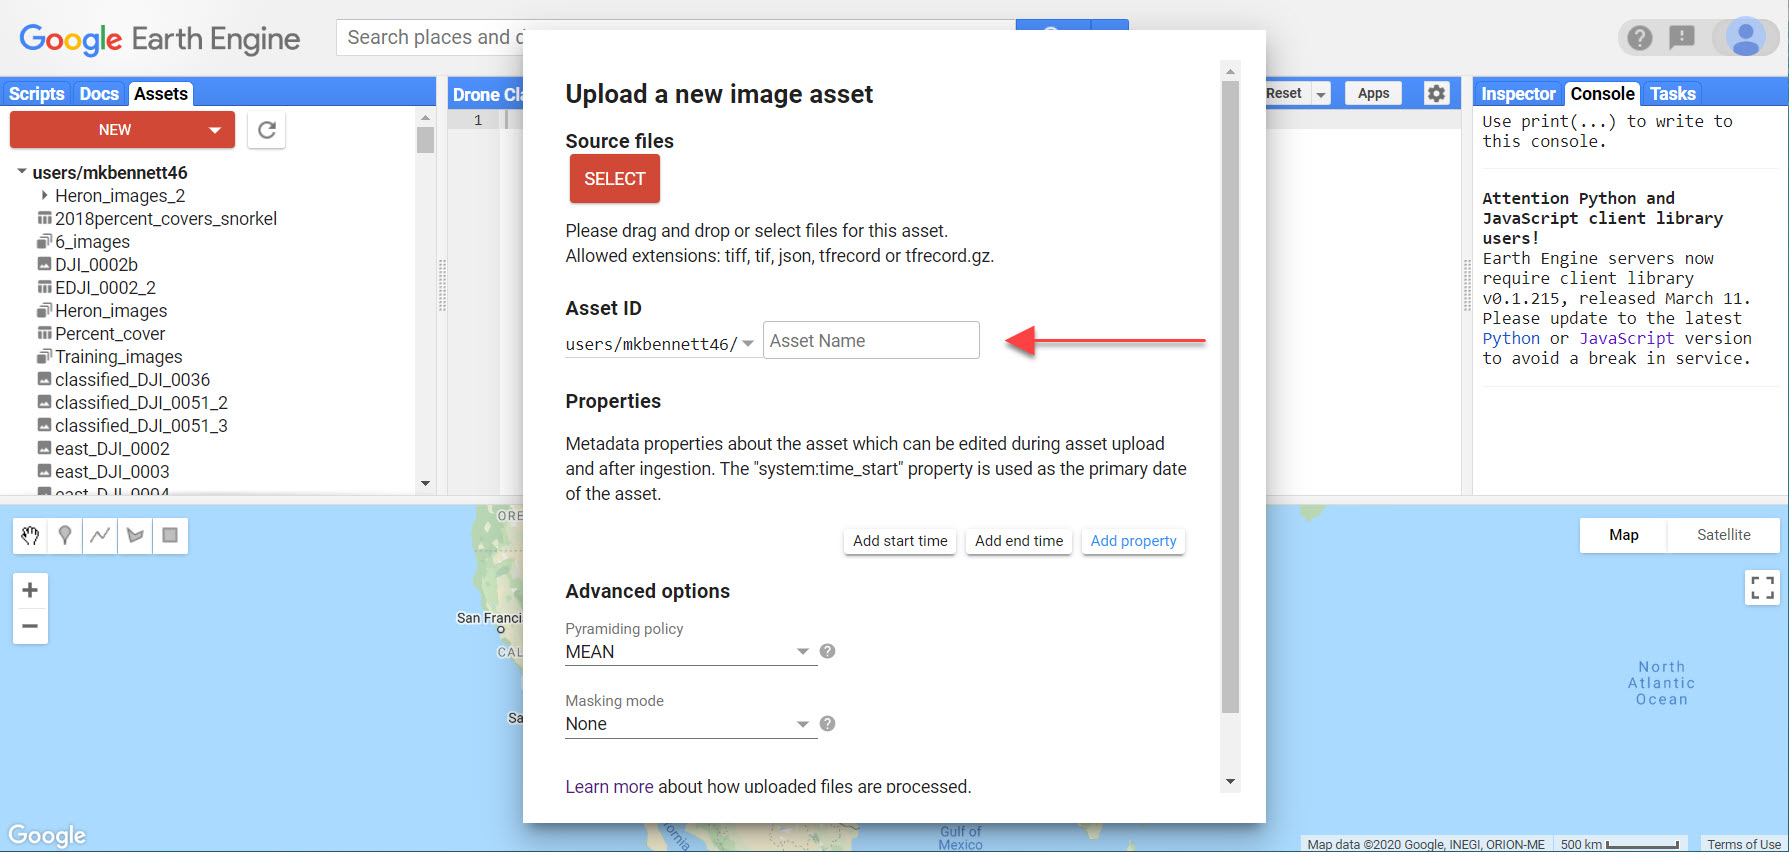


## Create a new image collection

After uploading drone image GeoTIFFs, under "New" we click "Image collection" to create a new Image Collection.

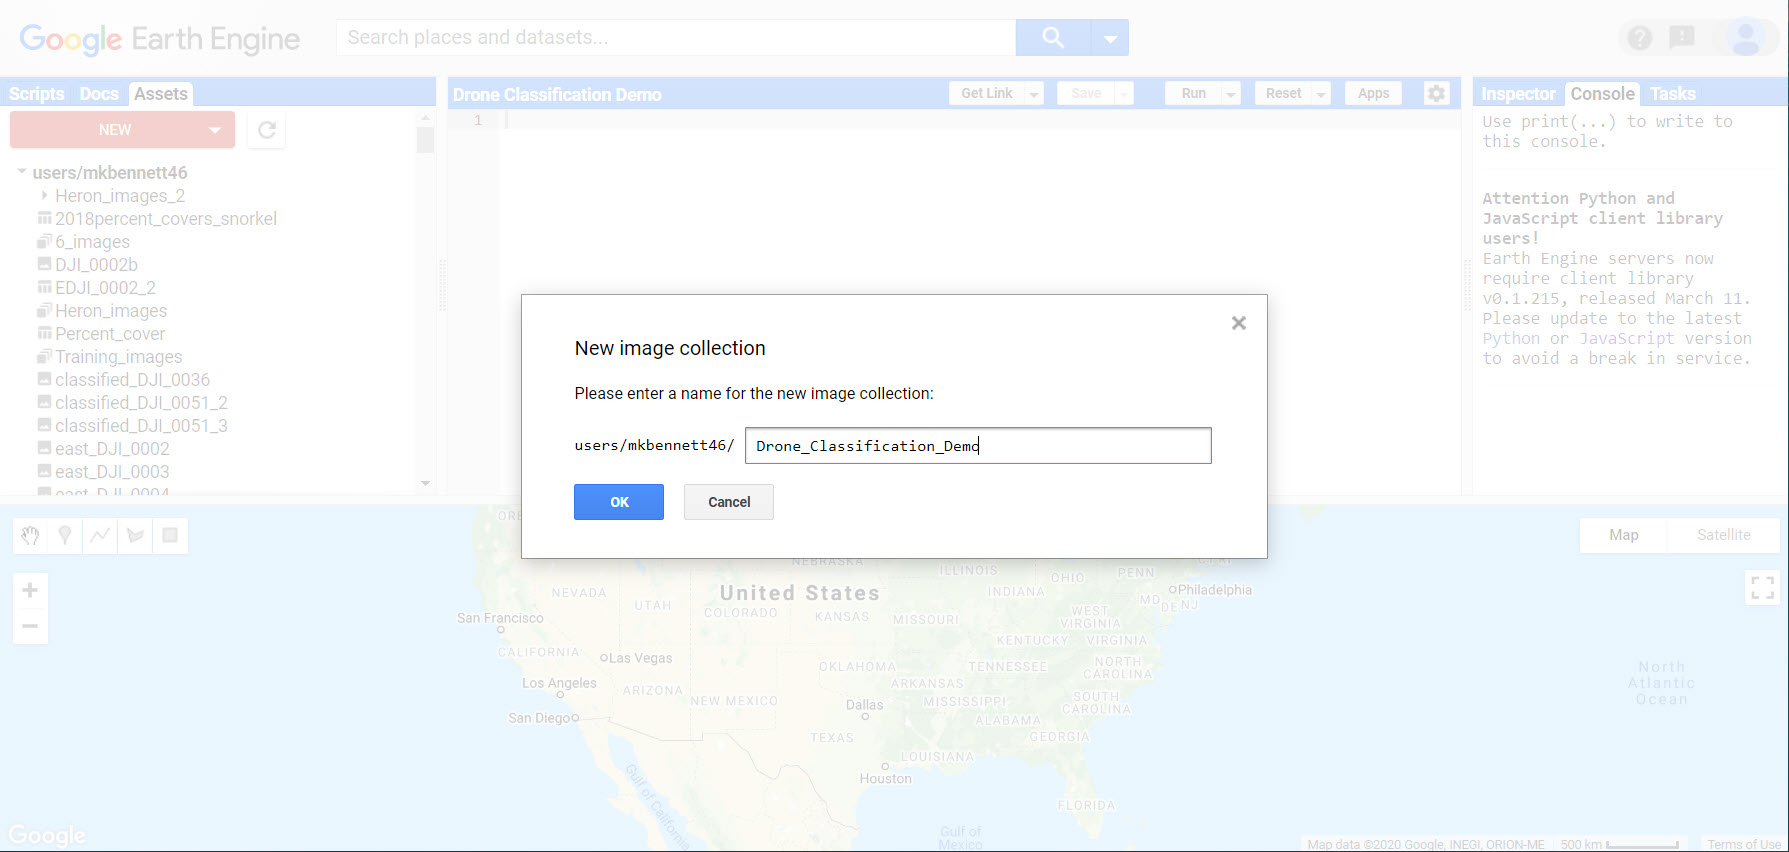


We then click and drag the assets we want into the "Done_Classification_Demo" image collection. 



# Data Collection

Under "Scripts" we select "New" and create a new script file for our classification. We then select the new file so the blank script file shows in the center console. 


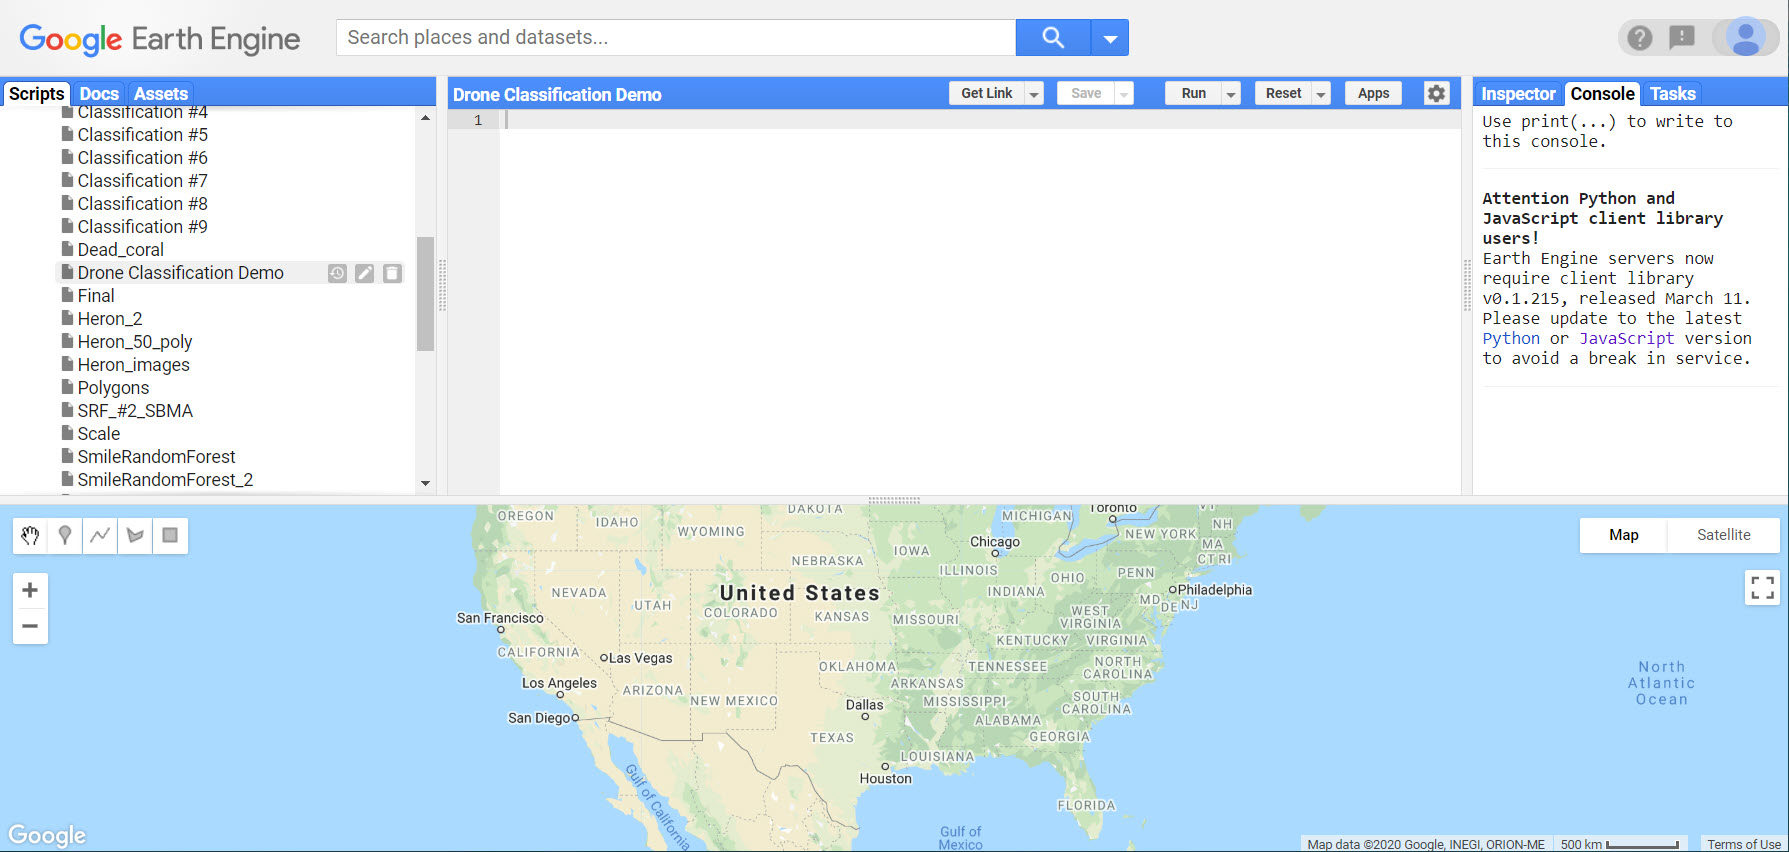


We select "Assets" and find the "Drone_Classification_Demo" image collection. We click the arrow option to import the image collection into the "Drone Classification Demo" file. 

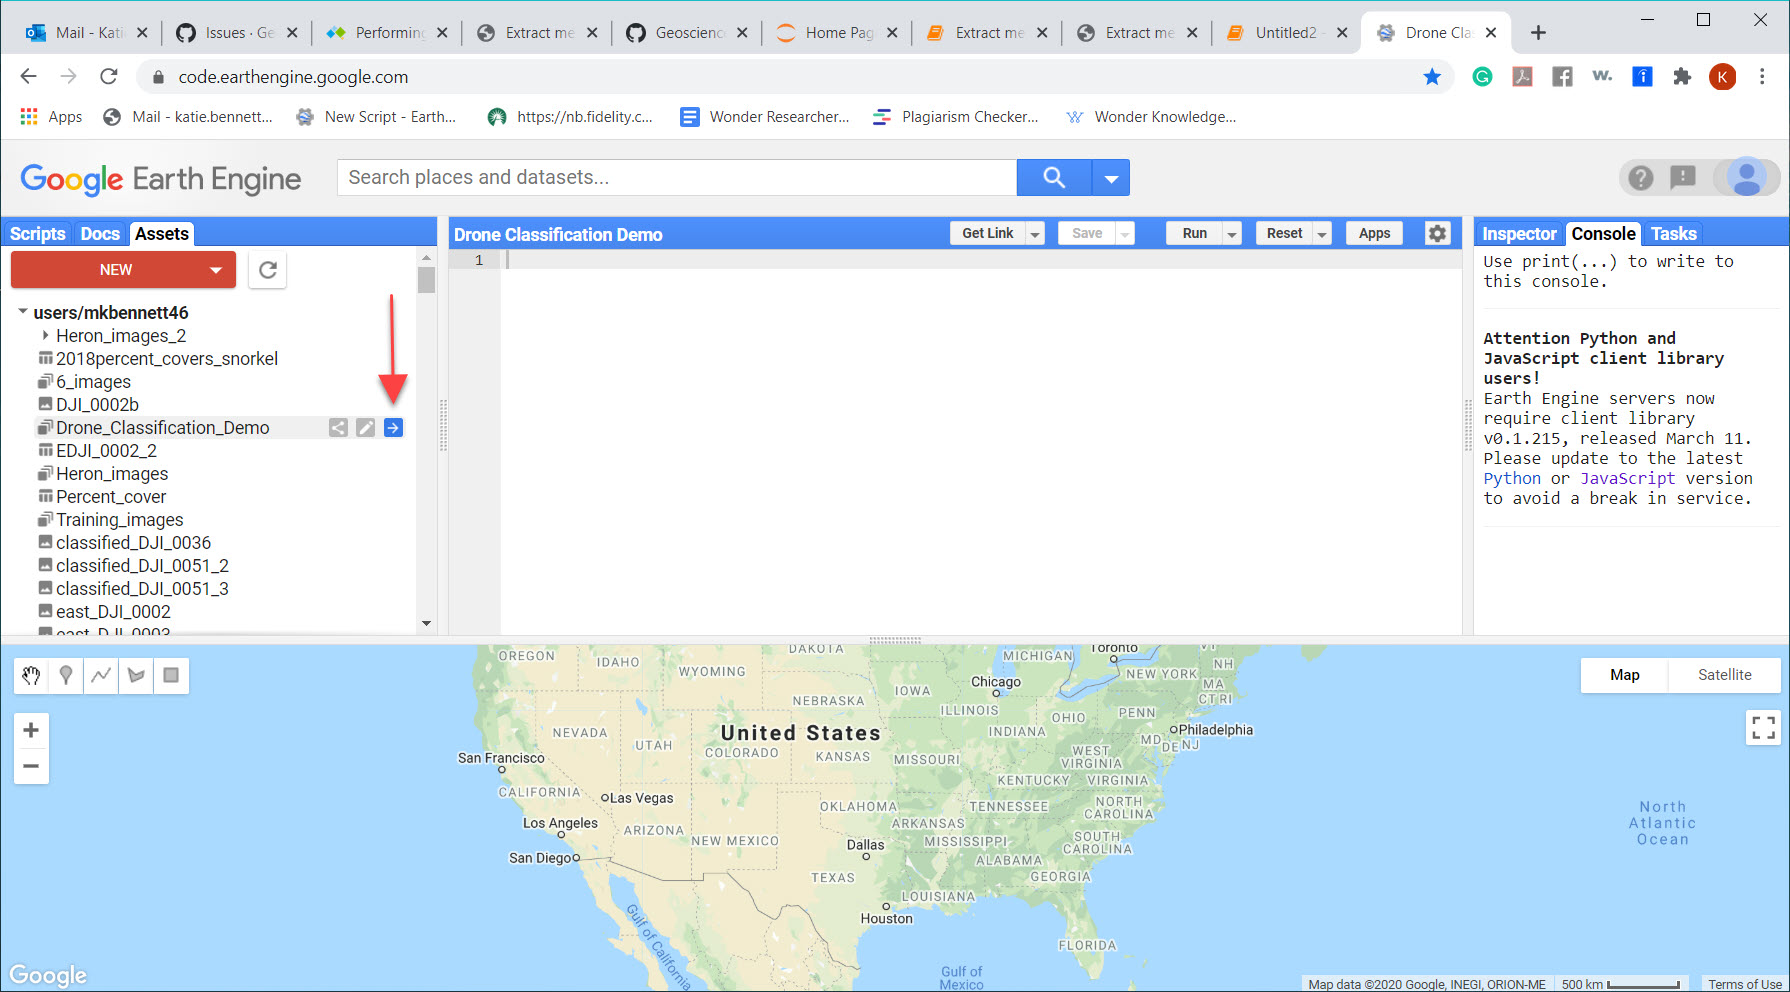



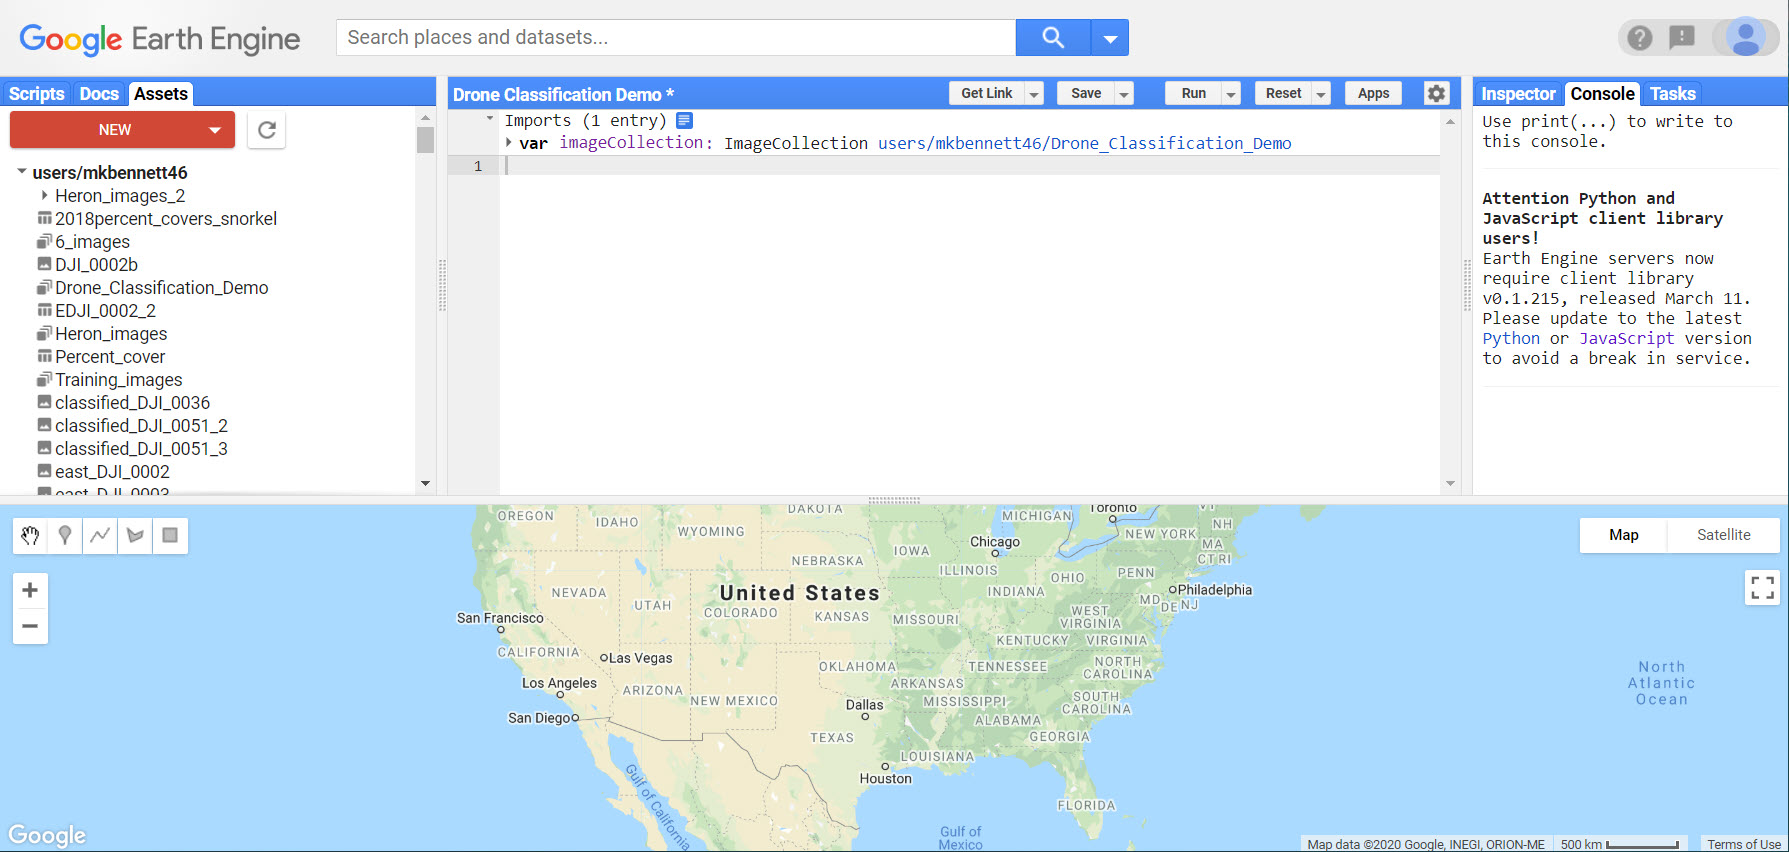


We change the image collection name to "Training". 

In the following cell, we add the the training image collection to the map and create a variable for the bands we use for classification. Five drone images of Heron Reef will display on the map.

In [ ]:
Map.addLayer(Training, "", "Heron Images"); // Adds drone image collection to the map
Map.centerObject(Training);

var bands = ['b3','b2','b1']; // Creates variable of bands for classification



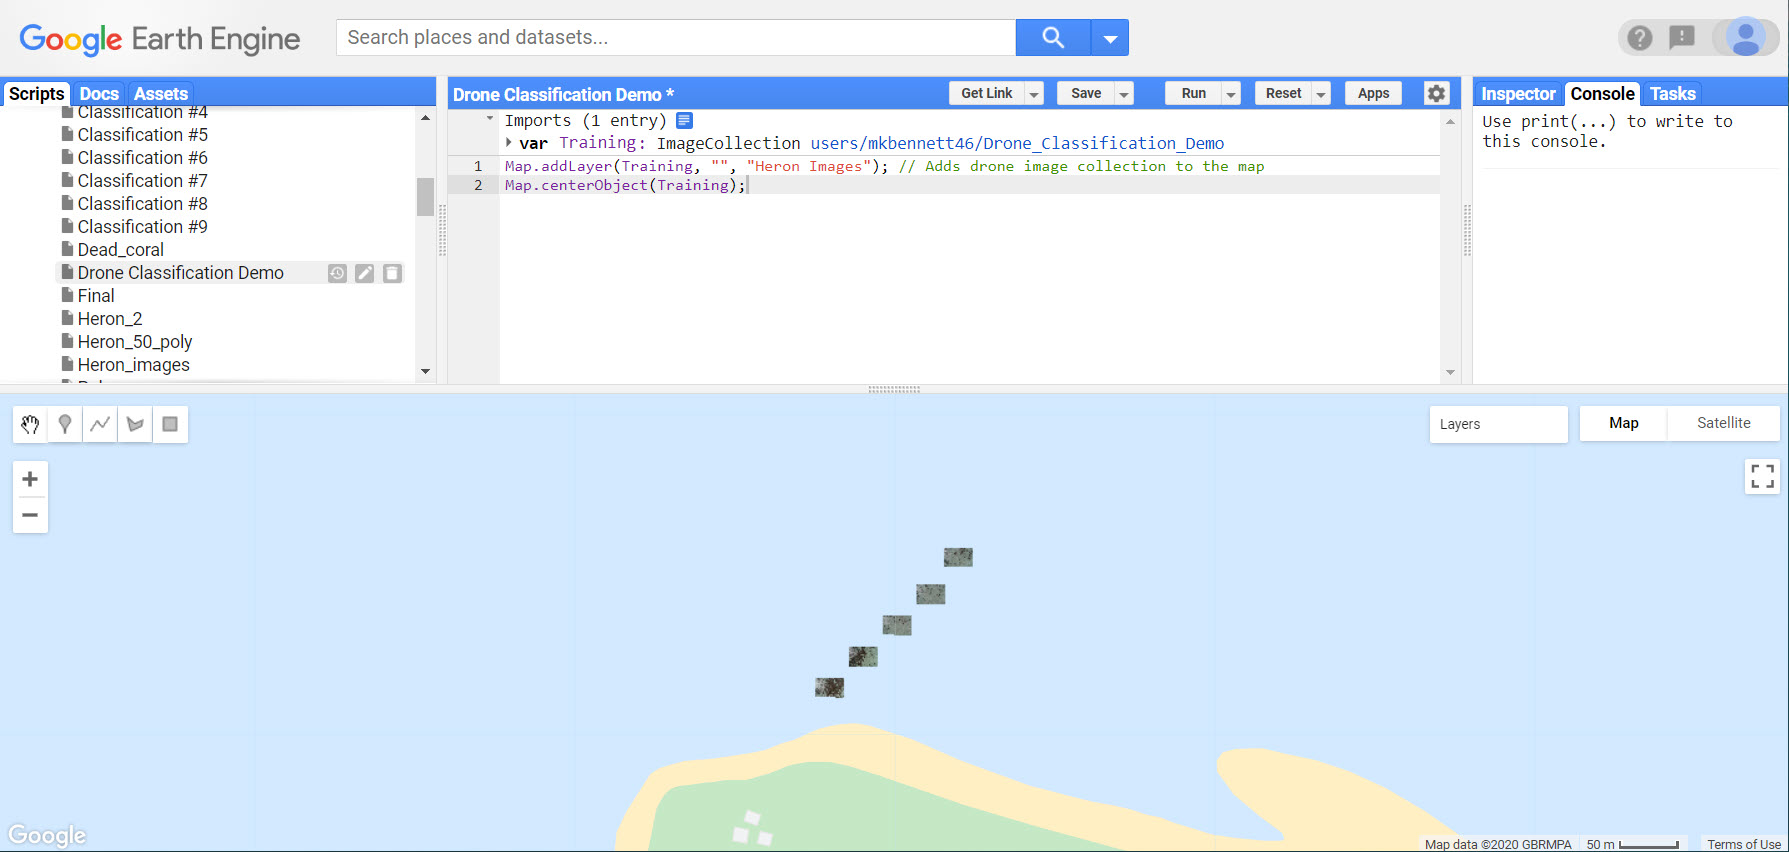

Next,  we zoom into the drone images and select the geometry tool to manually create polygons over the areas that represent the classes we want to classify.

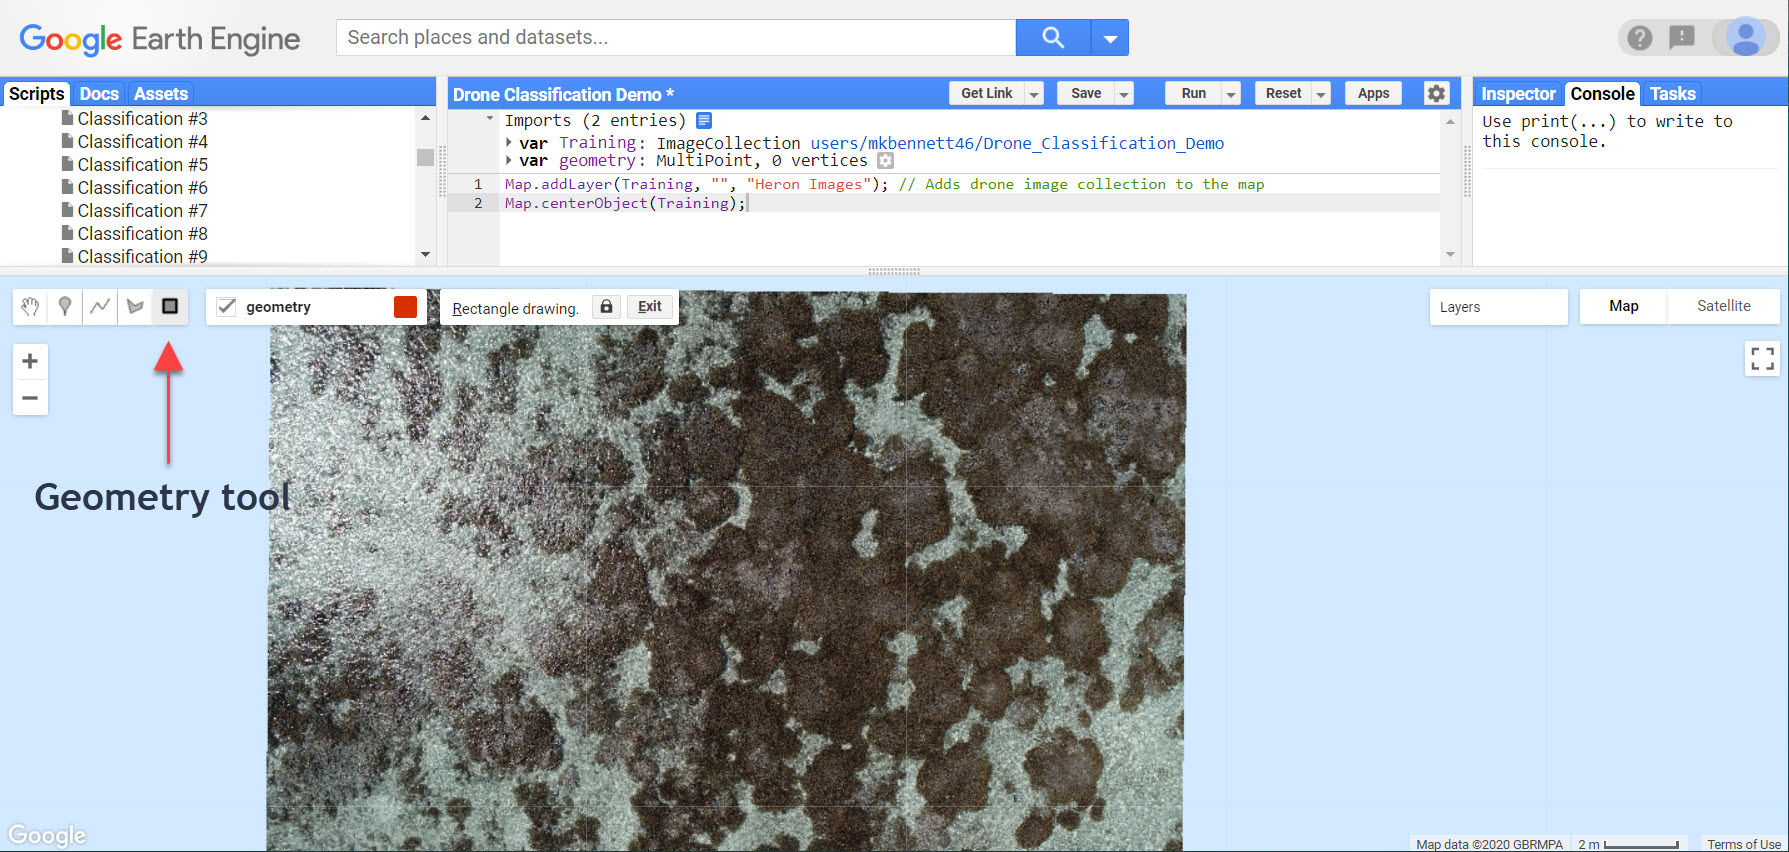


Under "Geometry Imports", we select "Edit Layer Properties":


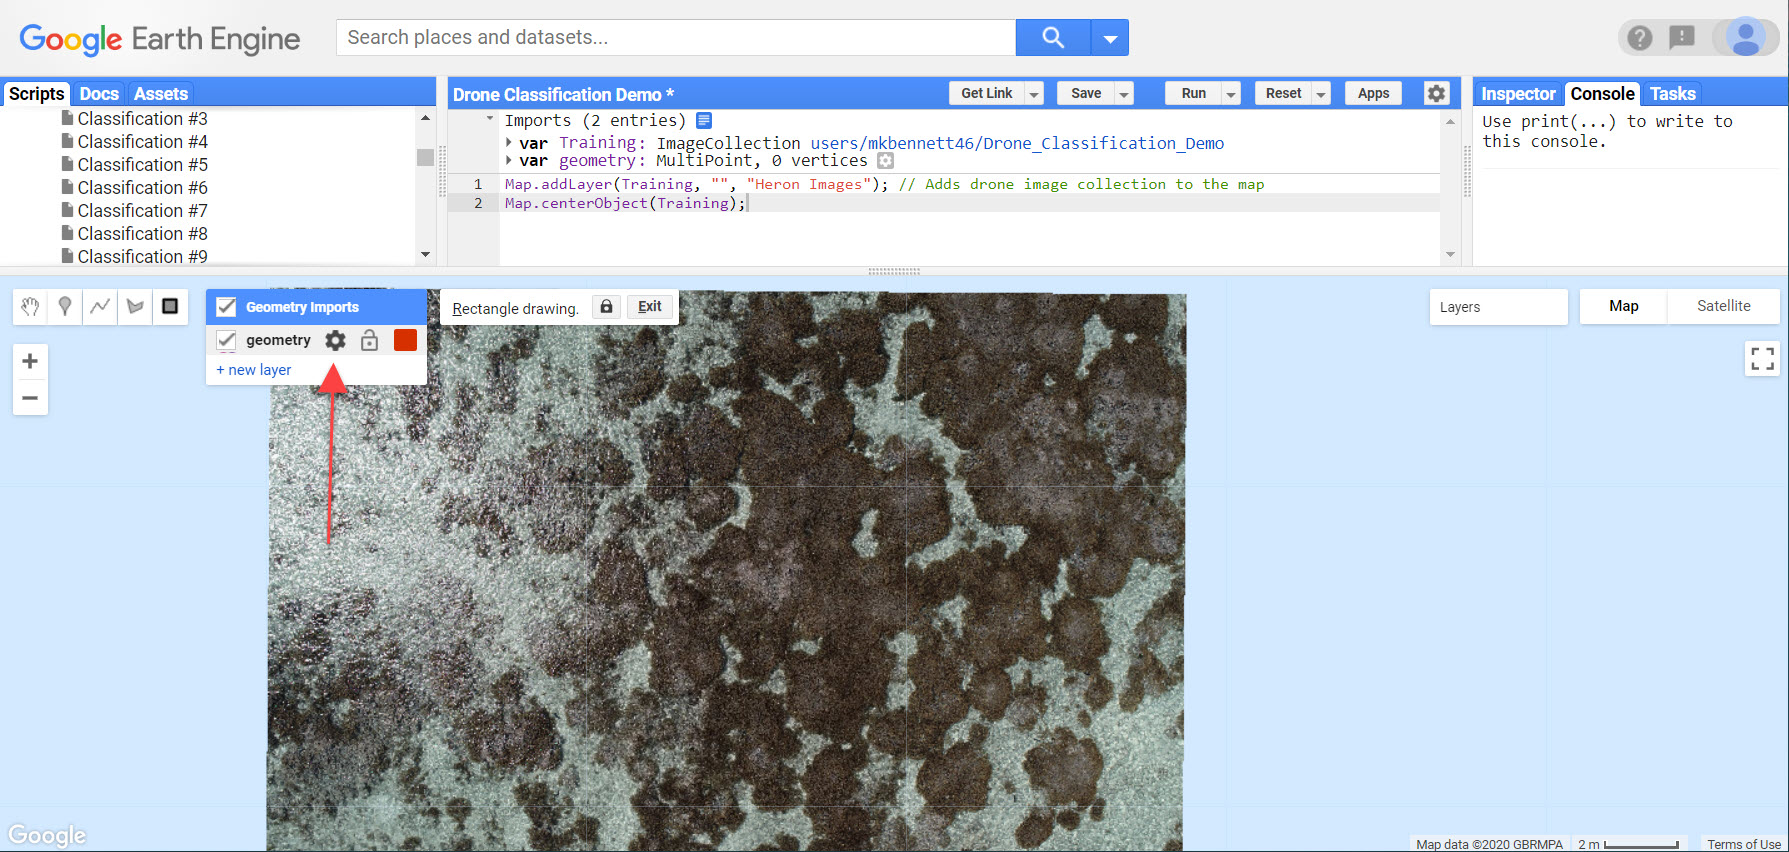


+ 1.) Under "Name"  we name this geometry import "LC" (for live coral). 
+ 2.) Under "Import as", we select "FeatureCollection". 
+ 3.) We select "+ Property"

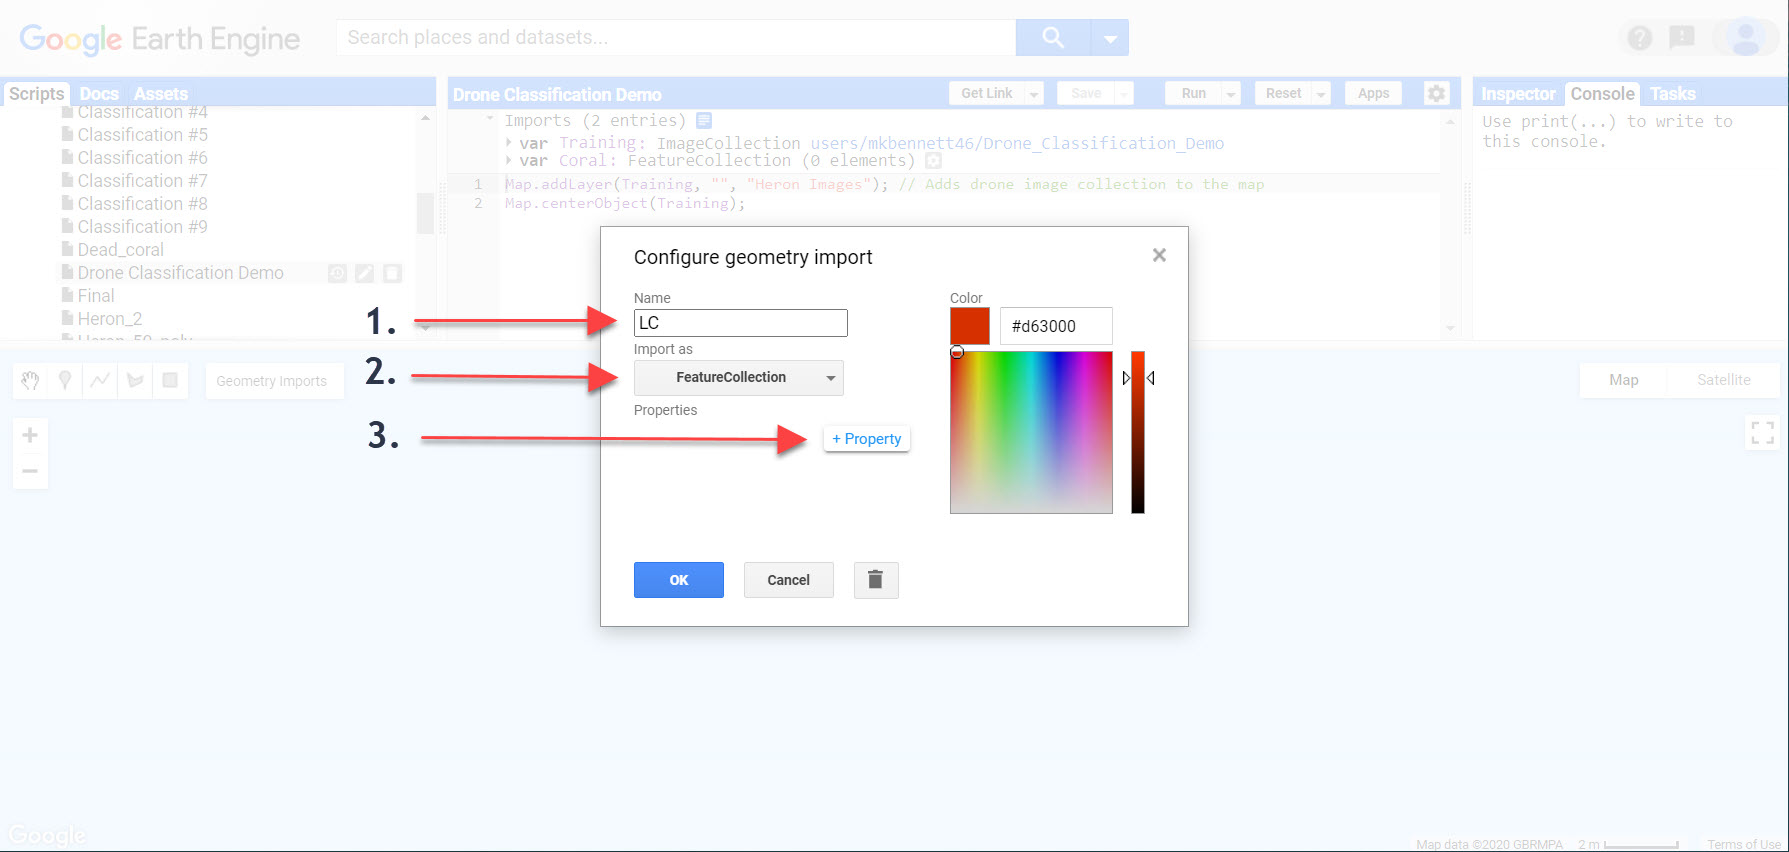


Under "Property" we type "Substrate". Under 'Value" we assign the number 0. 

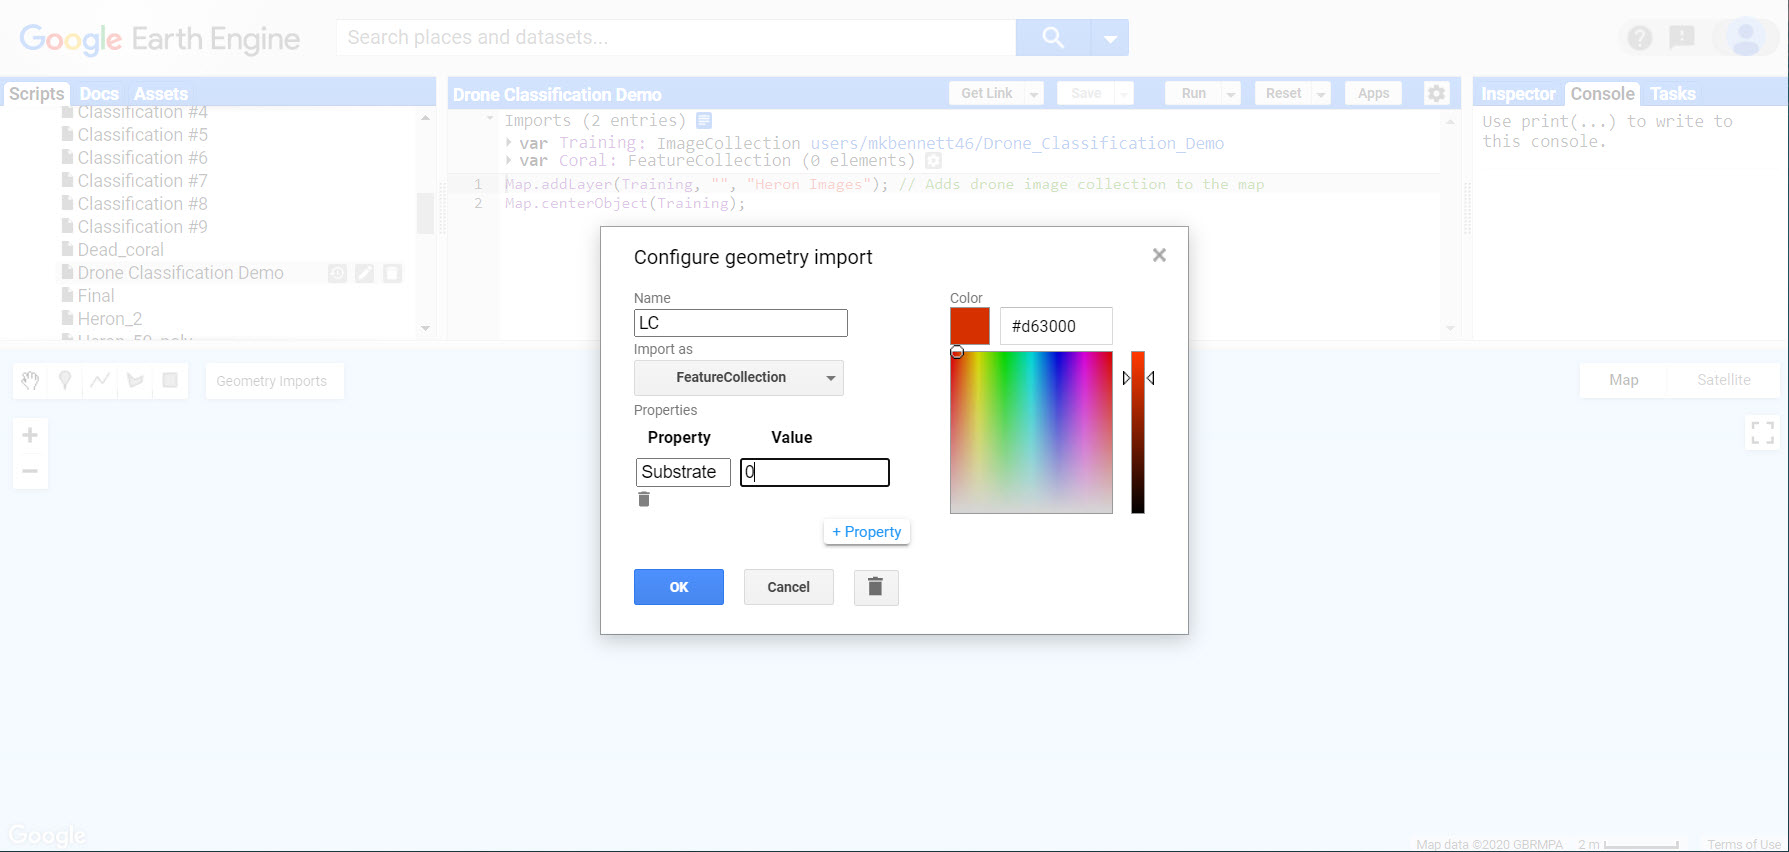


Now we are ready to start drawing our polygons! 

We click on the geometry tool. The "rectangle drawing" box appears and the "LC" geometry class under geometry imports is now checked and boldened (as it is selected for polygon drawing). 

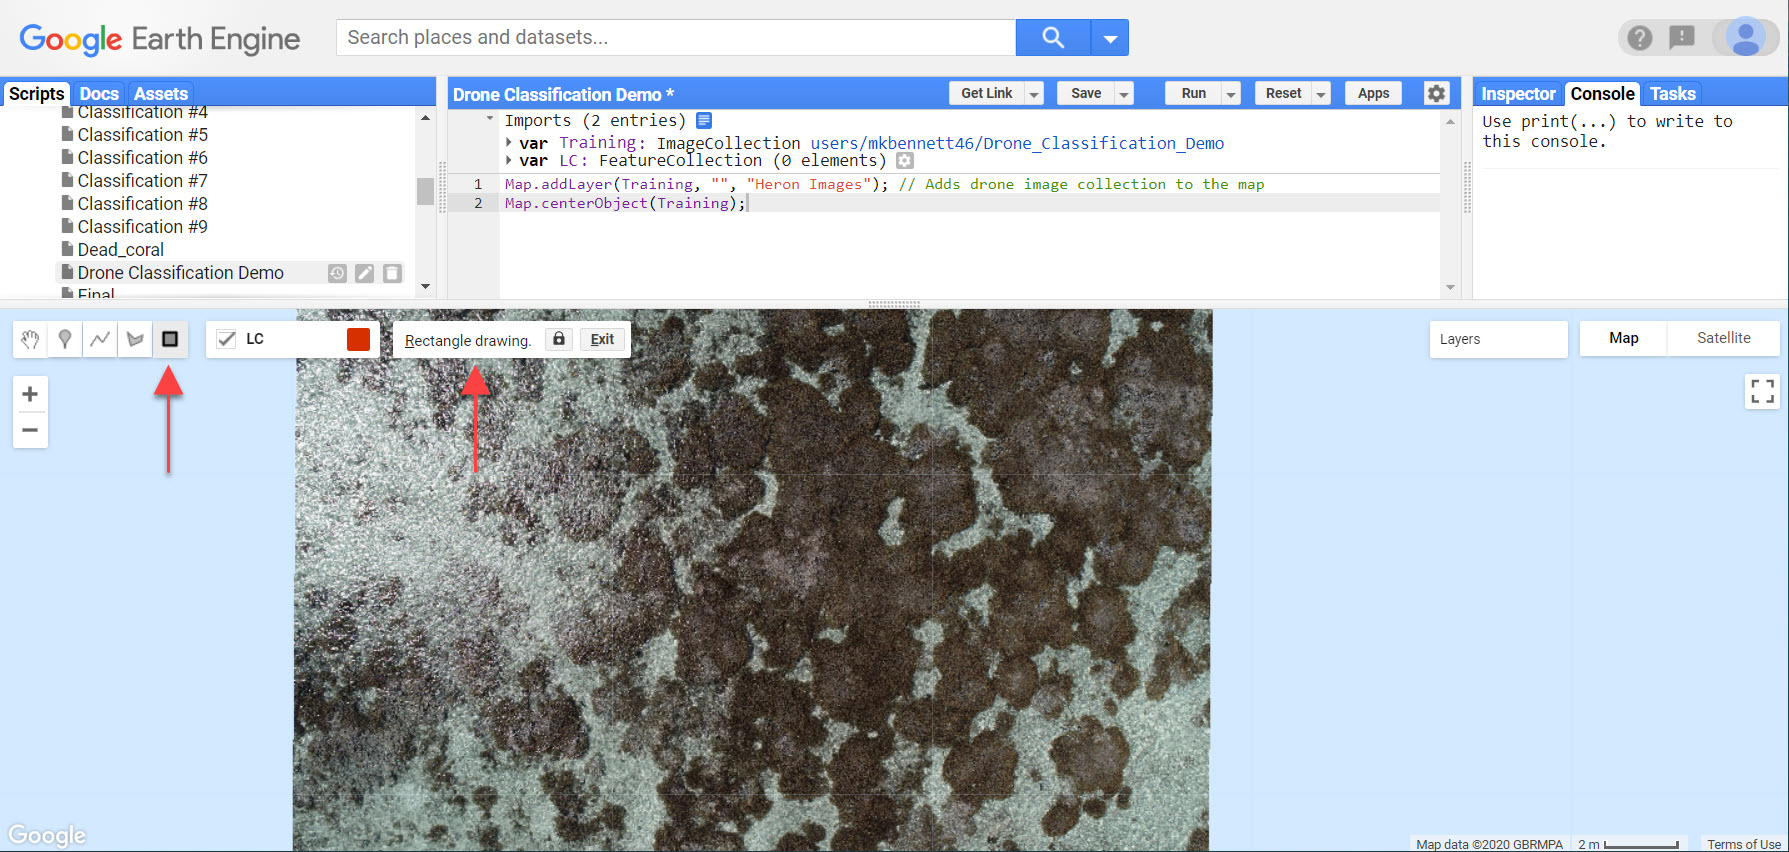

We select representational areas of coral. To draw polygons, we simultaneasouly click and drag the curser. The number of polygons we draw updates under the geometry imports section. So far, we've drawn three polygons:


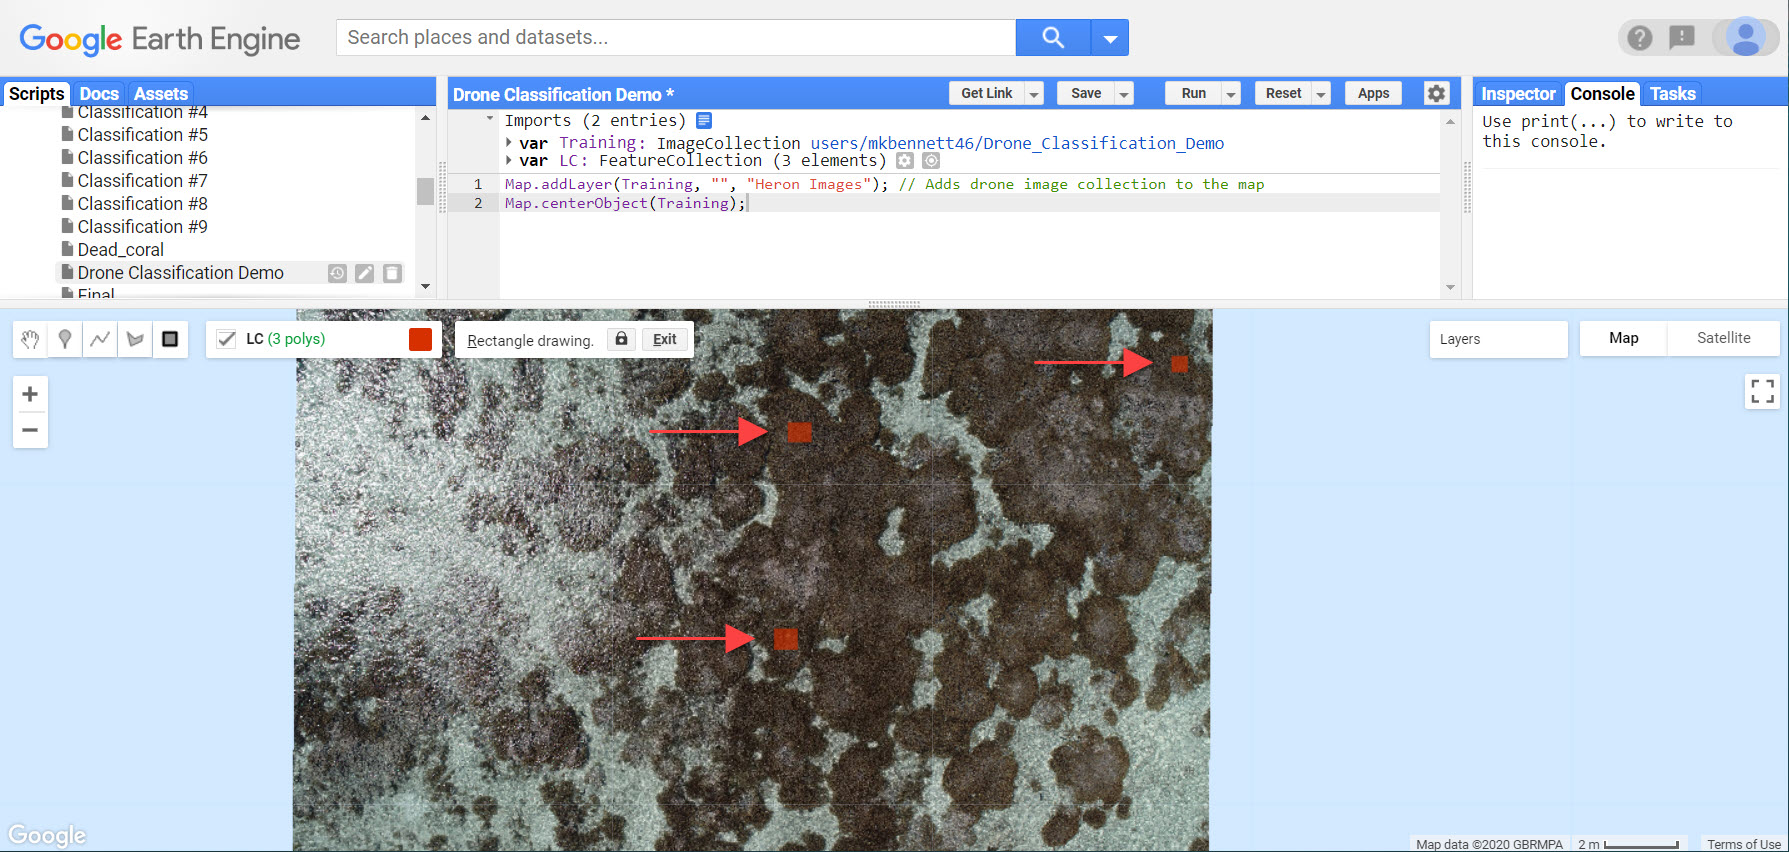


We create 30 polygons across the Heron Reef images. (In this demo, we will create 15 polygons as example). 

We repeat the above steps for each class: Live coral (LC), Rock, Sand, and Sunglint. We assign each class value after coral in " Edit Layer Properties" as '1' for Rock, '2' for Sand, and '3' for Sunglint. We also assign each class a different color. 

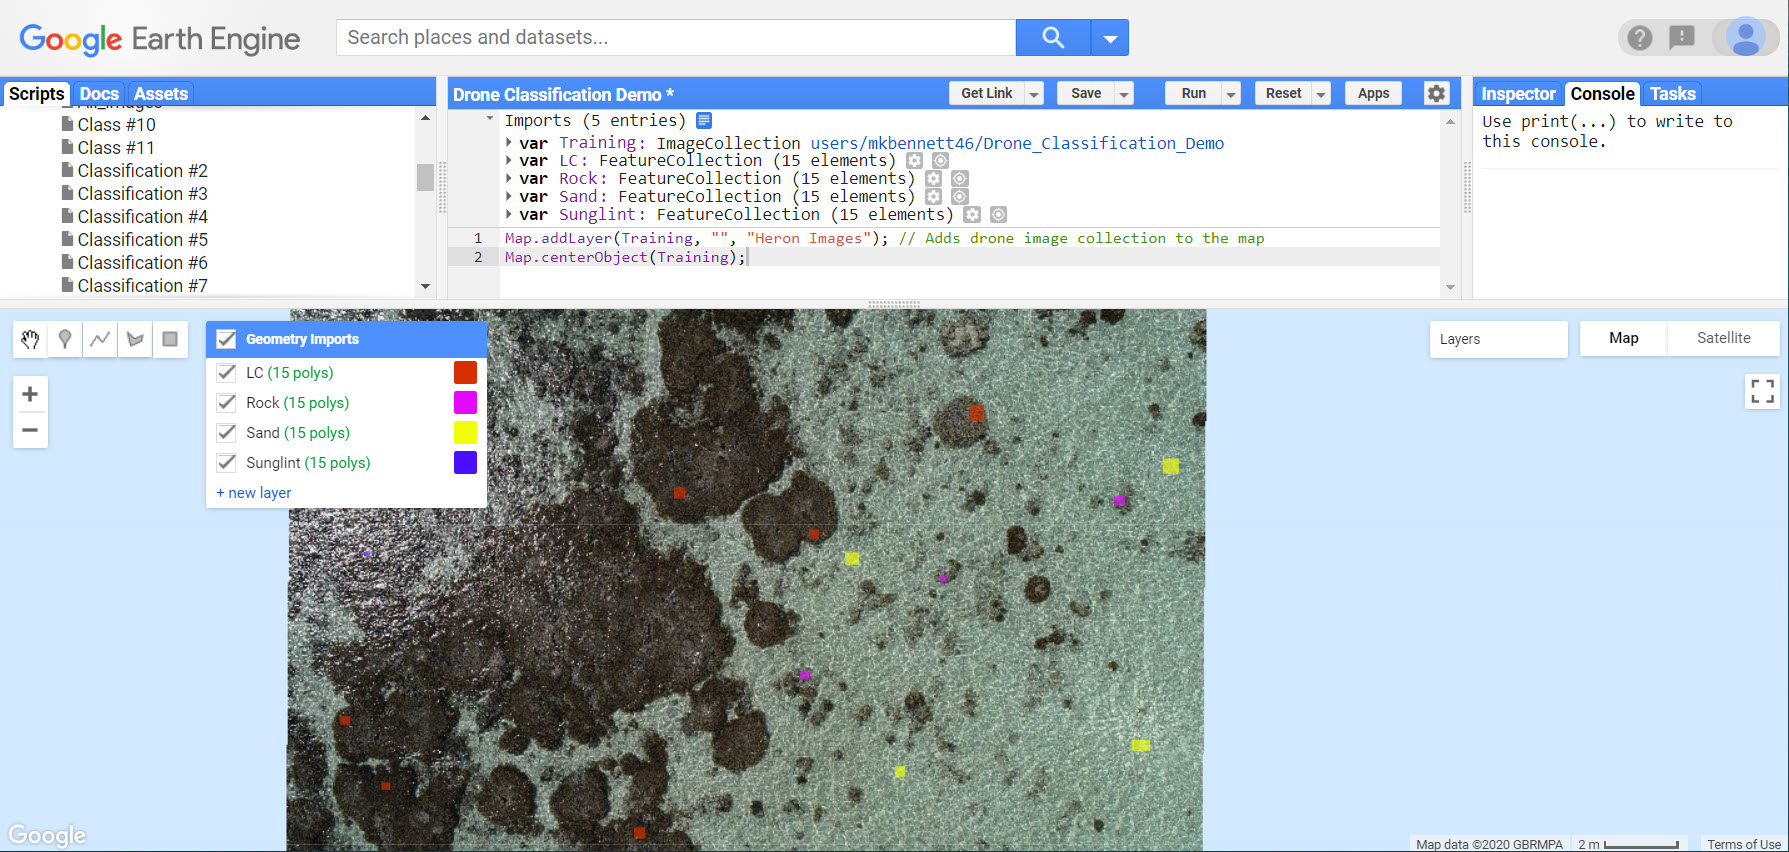

In the following cell, we sample the polygons with 8,000 random points per class:

In [ ]:
// Coral Class

// Create 8,000 random points in the Coral feature collection:
var LC_points = ee.FeatureCollection.randomPoints(LC, 8000);

// Set the substrate properties of each point in the (LC) feature collection:
var LC_points_2 = LC_points.map(function(ft){
  return ee.Feature(ft).set('Substrate', 0);
});
  
//print(LC_points_2);


//Rock Class

var Rock_points = ee.FeatureCollection.randomPoints(Rock, 8000);


// Set the substrate properties of each point in the Rock feature collection:
var Rock_points_2 = Rock_points.map(function(ft){
  return ee.Feature(ft).set('Substrate', 1);
});
  
//print(Rock_points_2);


 //Sand Class

var Sand_points = ee.FeatureCollection.randomPoints(Sand, 8000);


// Set the substrate properties of each point in the sand feature collection:
var Sand_points_2 = Sand_points.map(function(ft){
  return ee.Feature(ft).set('Substrate', 2);
});
//print(Sand_points_2);

//Sunglint

var glint_points = ee.FeatureCollection.randomPoints(Sunglint, 8000);


// Set the substrate properties of each point in the Sunglint feature collection:
var Glint_points_2 = glint_points.map(function(ft){
  return ee.Feature(ft).set('Substrate', 3);
});
  

//Merge each feature collection together  (w/ class properties ):

var random_points = (LC_points_2).merge(Sand_points_2).merge(Glint_points_2).merge(Rock_points_2);
//print(random_points);

# Split data into 70% training and 30% validation 

Here we split the data into 70% training and 30% validation. To ensure the data is evenly distributed across the classes, we generate a histogram that displays how many pixels per class are sampled for the training data and for the validation data. The histogram results will appear in the console at the right of the window. 

In [ ]:
//add collumn of random uniforms to the training feature class and split 70/30 for validating and testing:

var withRandom = random_points.randomColumn({ seed: 1 });


//reserve data for testing and for validation:

var split = 0.3;  // Roughly 70% training, 30% testing.
var trainingPartitionT = withRandom.filter(ee.Filter.gt('random', split)); // allocates 70.2% pixels for testing classifier
var testingPartition = withRandom.filter(ee.Filter.lte('random', split)); // allocates 29.8% of pixels for validation

//Display a histogram that shows the number of
//training pixels per class in training PartitionT:


var histogram1 = // results - LC (5642), Rock (5549), Sand (5644), Sunglint (5614) = 22449 pixels (70.2 % for validation)
    ui.Chart.feature
        .histogram(
            {features: trainingPartitionT, property: 'Substrate'})
        .setOptions({
          title: 'Number of Pixels per Substrate Class',
    hAxis: {
      title: 'Class',
      ticks: [{v: 0, f: 'LC'},
              {v: 1, f: 'Rock'},
              {v: 2, f: 'Sand'},
              {v: 3, f: 'Sunglint'}]
    },
    vAxis: {
      title: 'Number of Pixels'
    }
  });
  
  print(histogram1);


//Display a histogram that shows the number of
//training pixels per class in testingPartition:


var histogram2 = // results - LC (2358), Rock (2451), Sand (2356), Sunglint (2386) = 9551 pixels (29.8 % for validation)
    ui.Chart.feature
        .histogram(
            {features: testingPartition, property: 'Substrate'})
        .setOptions({
          title: 'Number of Pixels per Substrate Class',
    hAxis: {
      title: 'Class',
      ticks: [{v: 0, f: 'LC'},
              {v: 1, f: 'Rock'},
              {v: 2, f: 'Sand'},
              {v: 3, f: 'Sunglint'}]
    },
    vAxis: {
      title: 'Number of Pixels'
    }
  });
  
  print(histogram2);
    


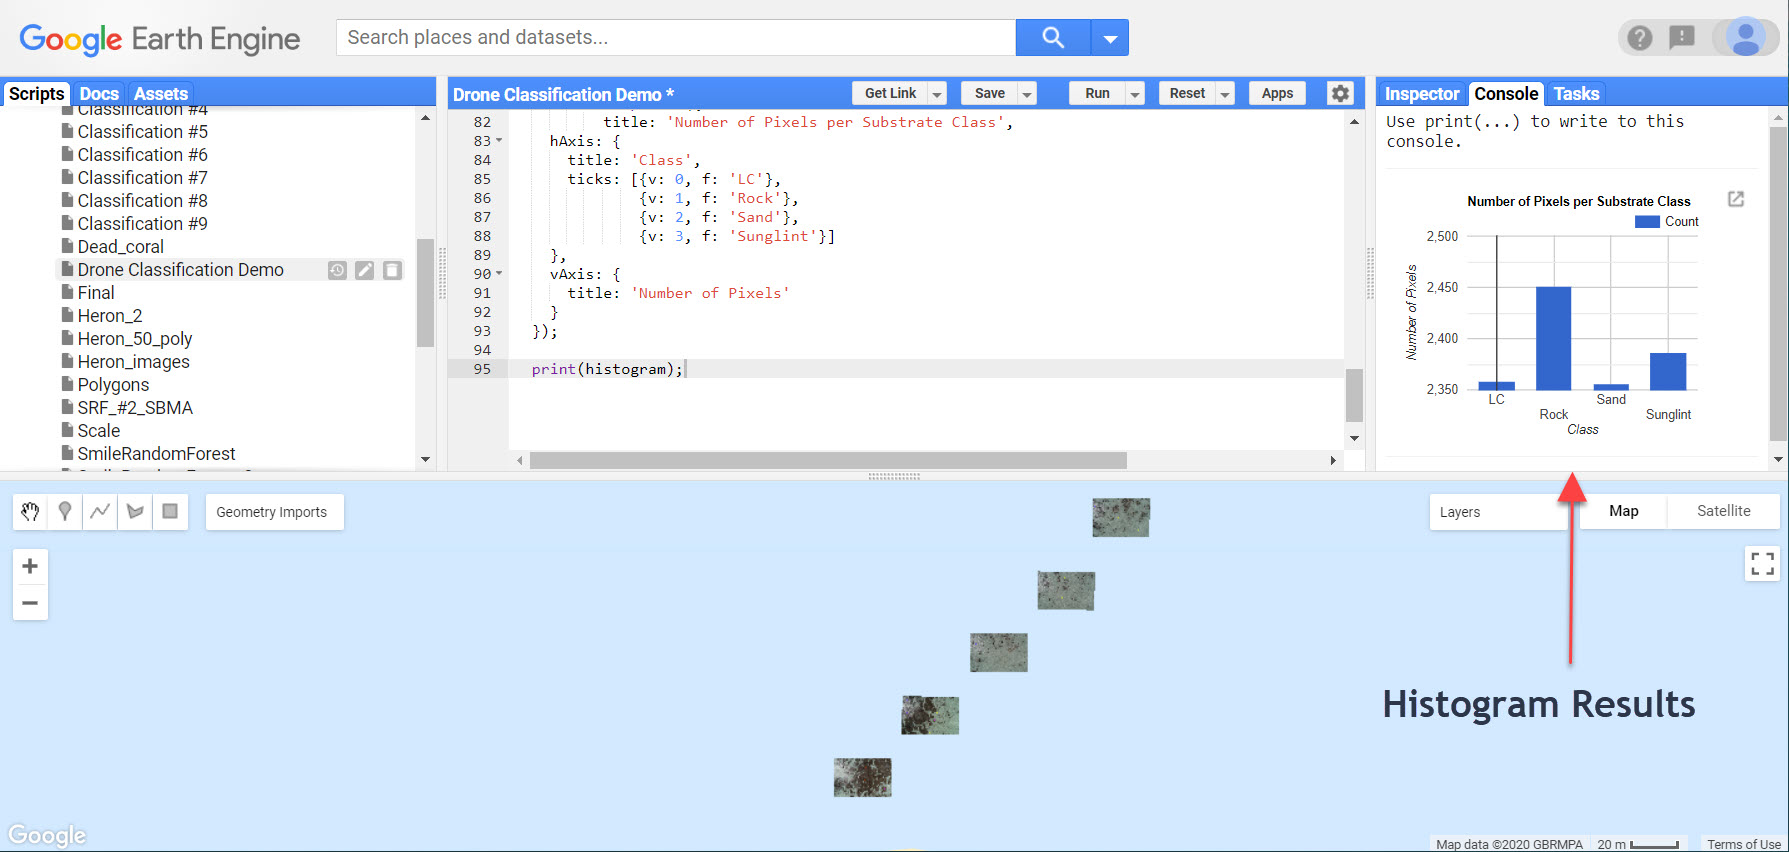

Next we train the Random Forest classifier.

In [ ]:
// function to extract all reflectance data from the trainingPartitionT points to train classifier:

var trainingImage_Collection = function(image){
  return image.select(bands).sampleRegions({
  collection: trainingPartitionT,
  properties: ['Substrate'],
  scale: 0.0045 // the GSD of the imagery 
})};

var trainingPartition = Training.map(trainingImage_Collection).flatten();
//print(training);  // returns training class points with substrate properties and band reflectance data



// Train classifier with training partition. smile.RandomForest explains
//the variable importance of each of the bands


//Create a Random Forest classifier and train it (can use any classifier)
//set Random Forest parameter at 50 trees
//Square root for the number of variables per split (default), 
//0.5 for the bag fraction, no limit on the maximum number of nodes (default)
//and 0 for the randomization seed (default)


var trainedClassifierSRF = ee.Classifier.smileRandomForest(50).train({ 
  features: trainingPartition,
  classProperty: 'Substrate',
  inputProperties: bands
});

var dict = trainedClassifierSRF.explain(); // gives variable importance to each band, as well as out of bag error estimate
print('Explain:',dict);


//Test accuracy of classifier

 var trainAccuracySRF = trainedClassifierSRF.confusionMatrix().accuracy(); // results: 0.97
print(trainAccuracySRF);

# Accuracy Assessment 

In the following cell, we classify the validation data and generate a confusion matrix to assess accuracy. Overall accuracy is also computed. To avoid a computation time out, the confusion matrix and accuracy result are exported as .CSV files to a Google Cloud Storage Bucket. 

In [ ]:
//   ACCURACY ASSESSMENT 

// Classify the image collection with trained Random Forest classifier:

var classifiedCollectionSRF = Training.select(bands)
  .map(function(image) {
    return image.classify(trainedClassifierSRF);
  });


//sample classification results to the validation areas (30% of training points left for validation)
//This function samples the classification of the pixel at each validation point: 

var Val_function = function(image){
  return image.sampleRegions({
  collection: testingPartition,
  properties: ['Substrate'],
  scale: 0.0045
})};




// map the classified collection with the Val_function to sample classification results 
// of validation points:

var Val_data = classifiedCollectionSRF.map(Val_function).flatten();



var confusionMatrixSRF = Val_data.errorMatrix('Substrate', 'classification');

var testAccuracySRF=  confusionMatrixSRF.accuracy();


var exportconfusionMatrixSRF = ee.Feature(null, {matrix: confusionMatrixSRF.array()}); 

var exporttestAccuracySRF = ee.Feature(null, {matrix: testAccuracySRF}); 



Export.table.toDrive({
  collection: ee.FeatureCollection(exportconfusionMatrixSRF),
  description: 'confusionMatrix',
  fileFormat: 'CSV'
});


Export.table.toDrive({
  collection: ee.FeatureCollection(exporttestAccuracySRF),
  description: 'Accuracy',
  fileFormat: 'CSV'
});
*/

To view exports, we select "Tasks". We click "Run", select "Google Cloud Storage" and type the name of the storage bucket we want to export our confusion matrix and accuracy results to. 

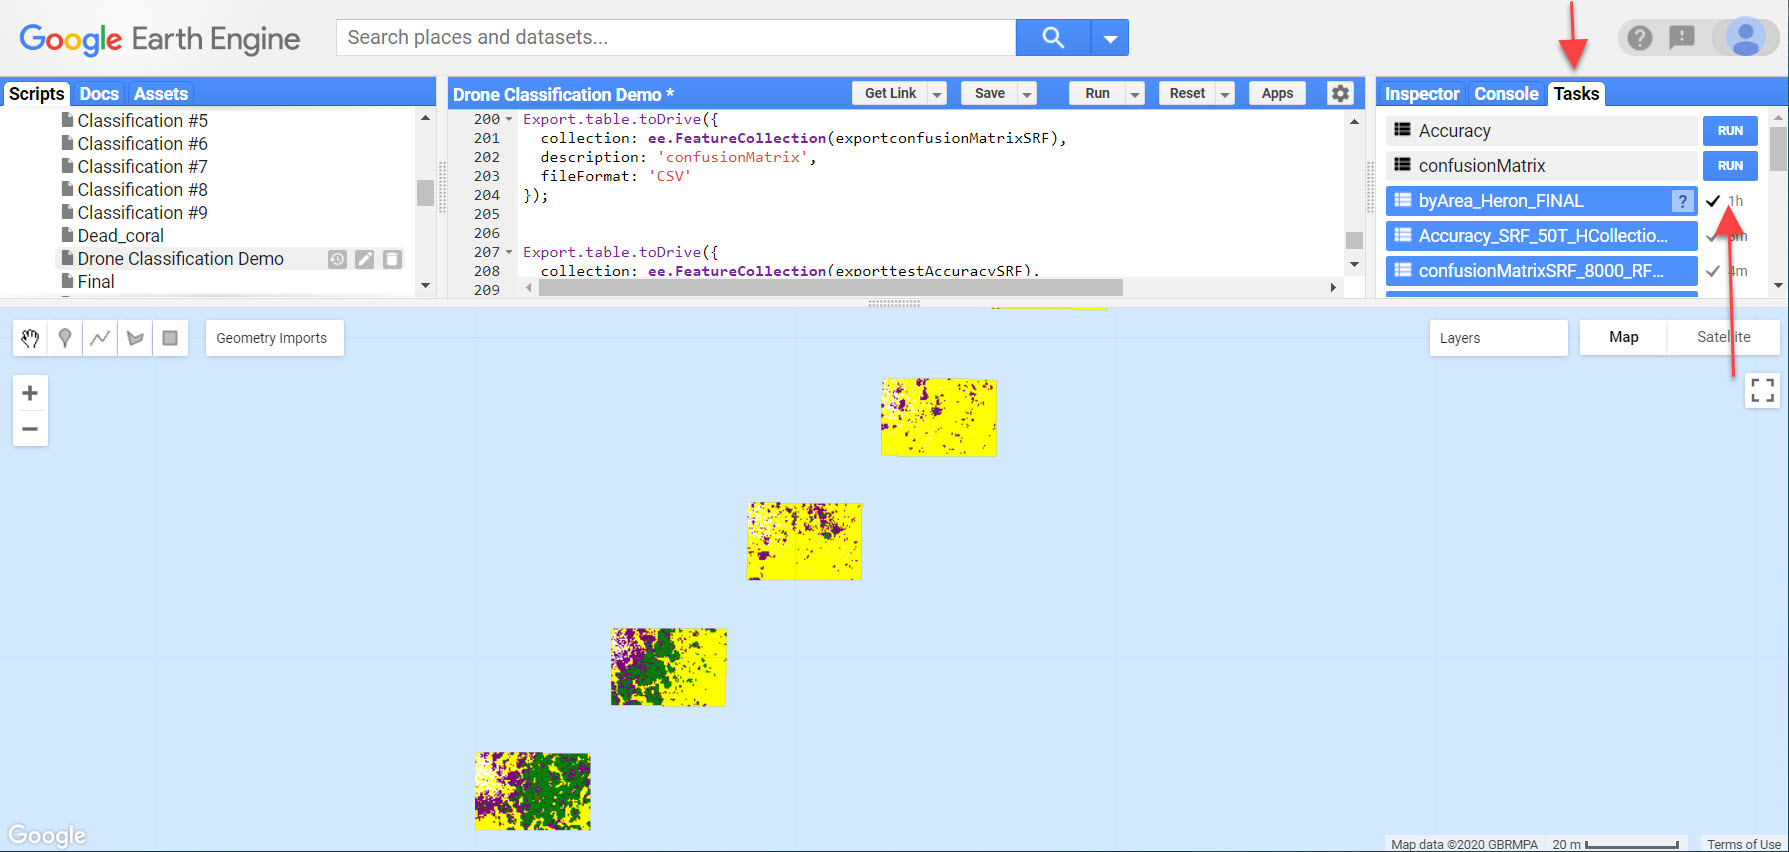

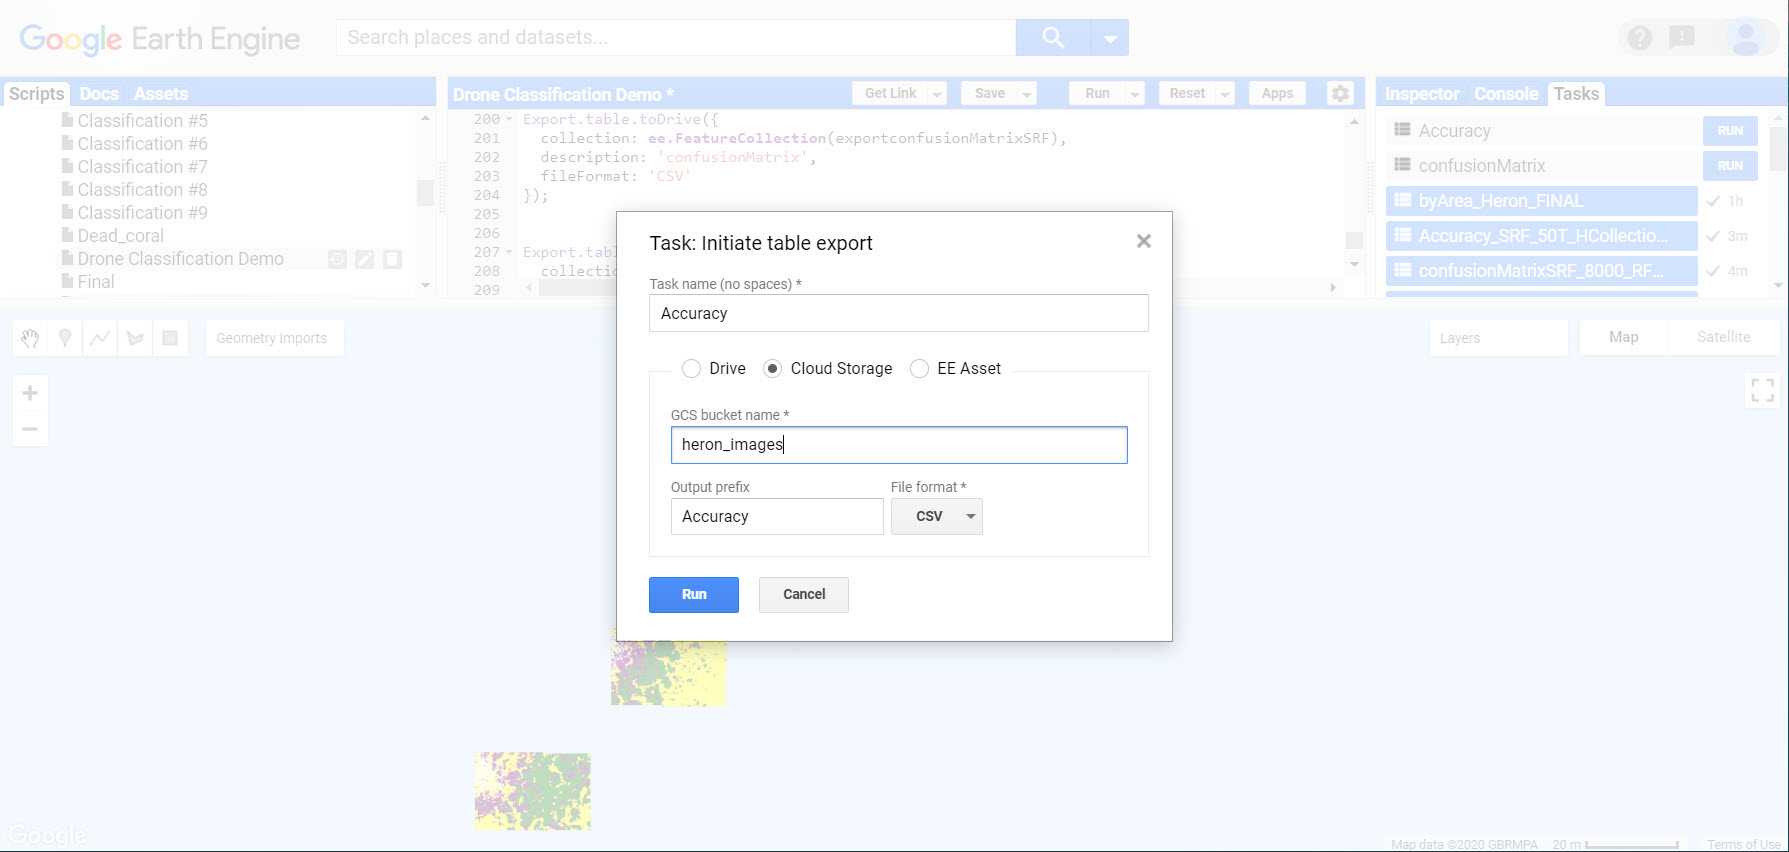

#  View the classification results

 All classified images will now show up on the map. 

In [ ]:

// View the classified image collection:

Map.addLayer(classifiedCollectionSRF, 
{min: 0, max: 3, palette: ["green","purple","yellow","white"]}, //colors chosen need to match the order of the geometry import variables 
'classification');

//Green = Coral
// purple = Rock
// yellow = Sand
// white = Sunglint



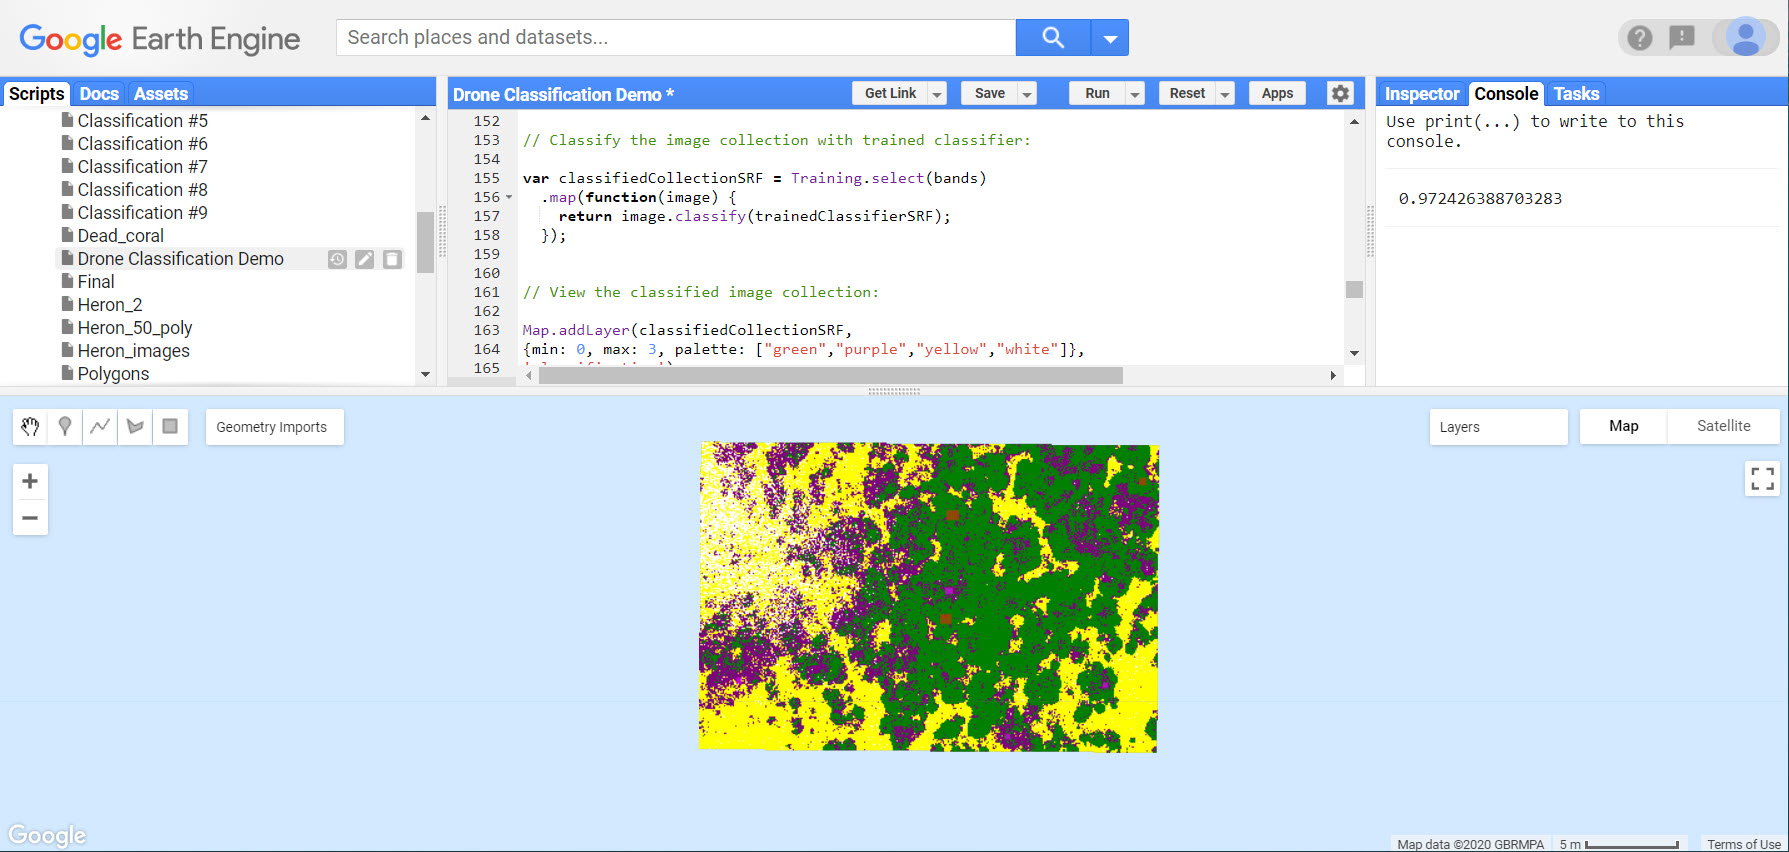

Unclassified Drone Image: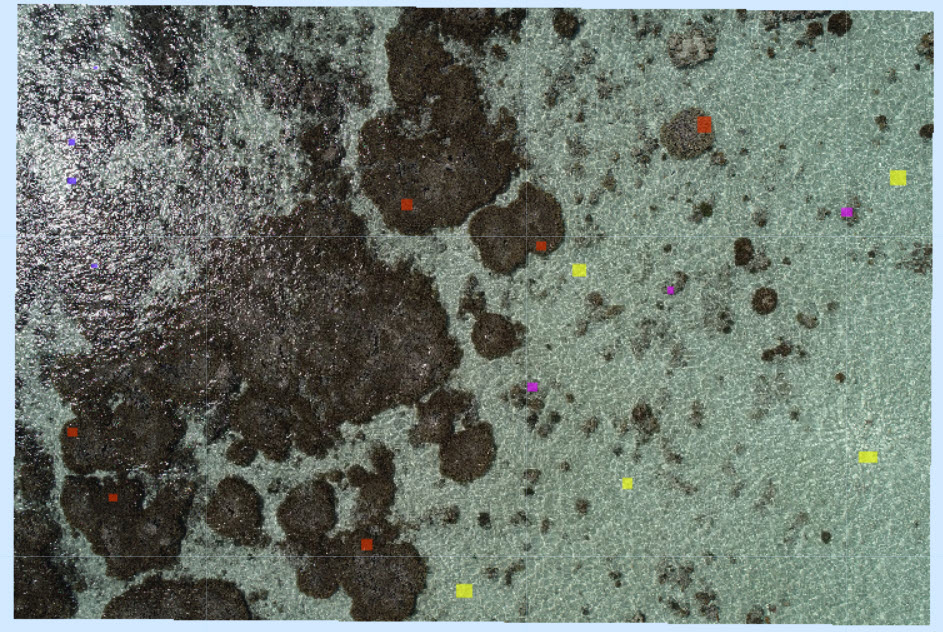


Classified Drone Image: 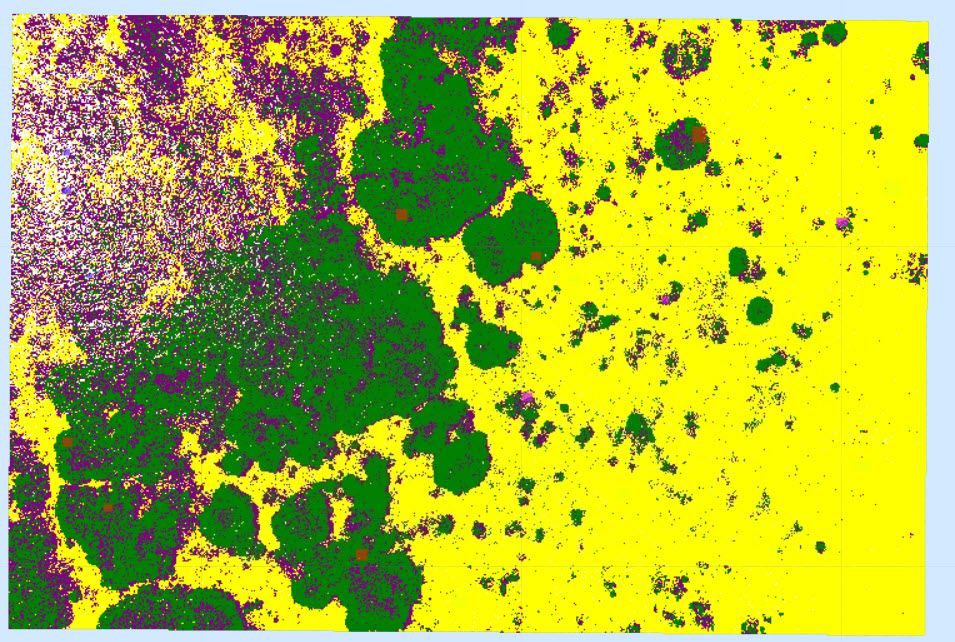

## *Note: If image collection is large, veiwing the classified collection as is may result in a computation time out. If this occurs, we need to .mosaic the collection to view as a single image object and avoid time outs. 

In [ ]:
/* Mosaic image collection: creates one image object (to view classification result 
of the entire image collection). This works to display the classification result over 
the entire image collection when mapped and avoids computation time out.*/ 

var mosaic_collection = Training.mosaic(); 


// Classify the mosaic (to view classified result):
var classifiedCollectionSRF = mosaic_collection.select(bands).classify(trainedClassifierSRF);


//Add layer to map - maps the classified image object 
Map.addLayer(mosaic_collection, '', 'Collection');

// Add viewing parameters to add colors to each substrate classification. Colors need to be in the same order
// as the classes are listed in the imports (above)

Map.addLayer(classifiedCollectionSRF, 
{min: 0, max: 3, palette: ["green","purple","yellow","white"]},
'classification');

# Extra Options

## We can calculate the area (m2) of each class in each drone image and export as a .CSV file

*Note: As some of our drone images overlap, we recognize it may be important to calculate the substrate areas of the overlapping regions. This function iterates through every drone image and calculates the areas for these overlapping regions. However, this results in blank data rows for images that do not overlap. Sorting the .CSV file may be needed to clearly display substrate areas for each drone image. 

In [ ]:
// Calculate classified area per substrate per drone image and export as .CSV


var fields = ['LC', 'Rock', 'Sand', 'Sunglint'];
var byArea = classifiedCollectionSRF.map(function(image) {
  return image.select('classification').eq([0, 1, 2, 3]).rename(fields)
  .multiply(ee.Image.pixelArea())
  .reduceRegions({
    collection: Heron_images, 
    reducer: ee.Reducer.sum()
    , 
    scale: 0.0045})
}).flatten();

Export.table.toDrive({
  collection: byArea, 
  description: 'byArea_Heron', 
  fileFormat: 'CSV'
});

## We can export classified images to Google Cloud Storage

In [ ]:
// Export a single classified drone image to Google Cloud Storage

var palette = ["green","purple","yellow","white"];

var classified = assetID.select(bands).classify(trainedClassifierSRF);


Export.image.toDrive({
  image: classified.visualize({min:0 , max: 3, palette: palette}),
  description: "east_DJI_0074", 
  region: assetID.geometry(), 
  scale: 0.0045, 
  skipEmptyTiles: true,
  fileFormat: 'GeoTIFF',
  crs: "EPSG:32756",
  maxPixels: 1e11
}); 


# License

**License:** The code in this notebook is licensed under the Creative Commons by Attribution 4.0 license.

**Last modified:** August 2020